In [1]:
trial_number_ml = "002"
random_state_init = 420

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 14:51:54,129] A new study created in memory with name: no-name-43cafb2a-126b-452c-9f15-4fff08e7481c


[I 2024-05-01 14:52:22,966] Trial 2 finished with value: 0.6161907374109854 and parameters: {'n_estimators': 115, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6161907374109854.


[I 2024-05-01 14:53:30,703] Trial 1 finished with value: 0.6152353233982467 and parameters: {'n_estimators': 537, 'max_depth': 35, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.6161907374109854.


[I 2024-05-01 14:54:22,092] Trial 3 finished with value: 0.622246772112679 and parameters: {'n_estimators': 603, 'max_depth': 69, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.622246772112679.


[I 2024-05-01 14:54:32,813] Trial 0 finished with value: 0.6244781031908085 and parameters: {'n_estimators': 862, 'max_depth': 93, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6244781031908085.


[I 2024-05-01 14:54:55,378] Trial 6 finished with value: 0.6139614380479281 and parameters: {'n_estimators': 158, 'max_depth': 97, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.6244781031908085.


[I 2024-05-01 14:55:19,508] Trial 4 finished with value: 0.6184251160617236 and parameters: {'n_estimators': 641, 'max_depth': 60, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6244781031908085.


[I 2024-05-01 14:55:30,116] Trial 8 pruned. 


[I 2024-05-01 14:55:32,884] Trial 5 finished with value: 0.618421560560347 and parameters: {'n_estimators': 471, 'max_depth': 67, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6244781031908085.


[I 2024-05-01 14:55:49,403] Trial 11 pruned. 


[I 2024-05-01 14:56:16,582] Trial 7 finished with value: 0.618743587399303 and parameters: {'n_estimators': 476, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6244781031908085.


[I 2024-05-01 14:56:52,673] Trial 13 pruned. 


[I 2024-05-01 14:57:06,943] Trial 9 finished with value: 0.6247980983146924 and parameters: {'n_estimators': 404, 'max_depth': 44, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6247980983146924.


[I 2024-05-01 14:58:31,432] Trial 12 finished with value: 0.6276678958542854 and parameters: {'n_estimators': 905, 'max_depth': 92, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 14:58:46,074] Trial 10 finished with value: 0.6254370727049239 and parameters: {'n_estimators': 958, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 14:59:08,639] Trial 17 pruned. 


[I 2024-05-01 14:59:22,799] Trial 14 finished with value: 0.6244781031908085 and parameters: {'n_estimators': 766, 'max_depth': 79, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 14:59:30,423] Trial 16 finished with value: 0.6222477879702151 and parameters: {'n_estimators': 312, 'max_depth': 82, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 14:59:36,004] Trial 15 finished with value: 0.6248006379585327 and parameters: {'n_estimators': 759, 'max_depth': 82, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 14:59:47,183] Trial 20 pruned. 


[I 2024-05-01 14:59:52,947] Trial 21 pruned. 


[I 2024-05-01 15:00:06,806] Trial 22 pruned. 


[I 2024-05-01 15:00:10,909] Trial 23 pruned. 


[I 2024-05-01 15:00:25,937] Trial 24 pruned. 


[I 2024-05-01 15:01:00,845] Trial 26 pruned. 


[I 2024-05-01 15:01:04,670] Trial 18 finished with value: 0.6168246325135363 and parameters: {'n_estimators': 783, 'max_depth': 80, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:01:21,979] Trial 19 finished with value: 0.6238370970855047 and parameters: {'n_estimators': 844, 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:01:56,147] Trial 28 pruned. 


[I 2024-05-01 15:02:13,301] Trial 29 pruned. 


[I 2024-05-01 15:02:56,190] Trial 25 finished with value: 0.6206533995672447 and parameters: {'n_estimators': 695, 'max_depth': 83, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:05:25,885] Trial 27 finished with value: 0.6247945428133159 and parameters: {'n_estimators': 909, 'max_depth': 88, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:05:32,296] Trial 31 finished with value: 0.6235211653917654 and parameters: {'n_estimators': 698, 'max_depth': 57, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:05:48,757] Trial 34 pruned. 


[I 2024-05-01 15:06:20,073] Trial 30 finished with value: 0.627664340352909 and parameters: {'n_estimators': 939, 'max_depth': 60, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:06:56,519] Trial 32 finished with value: 0.6267074025538658 and parameters: {'n_estimators': 874, 'max_depth': 60, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:07:00,057] Trial 36 pruned. 


[I 2024-05-01 15:07:08,157] Trial 35 finished with value: 0.6257504647548228 and parameters: {'n_estimators': 318, 'max_depth': 62, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:07:57,104] Trial 39 finished with value: 0.6193795142169263 and parameters: {'n_estimators': 229, 'max_depth': 53, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:08:32,069] Trial 33 finished with value: 0.6273473928016335 and parameters: {'n_estimators': 827, 'max_depth': 60, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:09:55,258] Trial 40 finished with value: 0.6235206574629973 and parameters: {'n_estimators': 570, 'max_depth': 71, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:09:55,303] Trial 37 finished with value: 0.6257494488972867 and parameters: {'n_estimators': 825, 'max_depth': 63, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:10:19,142] Trial 41 finished with value: 0.6273499324454739 and parameters: {'n_estimators': 588, 'max_depth': 71, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:10:28,680] Trial 43 pruned. 


[I 2024-05-01 15:10:40,836] Trial 38 finished with value: 0.623518625747925 and parameters: {'n_estimators': 997, 'max_depth': 52, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:11:47,067] Trial 44 finished with value: 0.6257555440425036 and parameters: {'n_estimators': 613, 'max_depth': 53, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 12 with value: 0.6276678958542854.


[I 2024-05-01 15:11:53,261] Trial 45 finished with value: 0.6295817714523715 and parameters: {'n_estimators': 605, 'max_depth': 74, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 45 with value: 0.6295817714523715.


[I 2024-05-01 15:11:58,273] Trial 46 finished with value: 0.6177846178851878 and parameters: {'n_estimators': 610, 'max_depth': 67, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 45 with value: 0.6295817714523715.


[I 2024-05-01 15:11:58,322] Trial 47 pruned. 


[I 2024-05-01 15:12:00,877] Trial 42 finished with value: 0.6244786111195766 and parameters: {'n_estimators': 871, 'max_depth': 53, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 45 with value: 0.6295817714523715.


[I 2024-05-01 15:12:03,813] Trial 49 pruned. 


[I 2024-05-01 15:12:09,952] Trial 48 finished with value: 0.6283083940308212 and parameters: {'n_estimators': 446, 'max_depth': 75, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 45 with value: 0.6295817714523715.


Best trial for RandomForestClassifier:
  Value: 0.6295817714523715
  Params: 
    n_estimators: 605
    max_depth: 74
    min_samples_split: 12
    min_samples_leaf: 2
    max_features: log2

Best hyperparameters for RandomForestClassifier: {'n_estimators': 605, 'max_depth': 74, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2024-05-01 15:12:18,494] A new study created in memory with name: no-name-612005cc-79ea-42e6-a071-9892d33eb9c0


RandomForestClassifier accuracy: 0.6153



[I 2024-05-01 15:12:27,555] Trial 0 finished with value: 0.6069515131198001 and parameters: {'n_estimators': 135, 'max_depth': 7, 'learning_rate': 0.08734692283358876, 'min_child_weight': 7, 'subsample': 0.7772599265112139, 'colsample_bytree': 0.9895601061146306, 'gamma': 0.12152030019306925, 'reg_lambda': 0.48559856482090474, 'reg_alpha': 0.012616943161987052}. Best is trial 0 with value: 0.6069515131198001.


[I 2024-05-01 15:12:27,871] Trial 2 finished with value: 0.6056725484818009 and parameters: {'n_estimators': 151, 'max_depth': 7, 'learning_rate': 0.13878383974933245, 'min_child_weight': 2, 'subsample': 0.5882322956230572, 'colsample_bytree': 0.6607573801309321, 'gamma': 3.5070635646079746, 'reg_lambda': 0.7224564596222254, 'reg_alpha': 0.028029025998737786}. Best is trial 0 with value: 0.6069515131198001.


[I 2024-05-01 15:12:30,379] Trial 3 finished with value: 0.6047120551813814 and parameters: {'n_estimators': 442, 'max_depth': 3, 'learning_rate': 0.2544266378727749, 'min_child_weight': 1, 'subsample': 0.6660022473805656, 'colsample_bytree': 0.5497796679290714, 'gamma': 4.3958398974049135, 'reg_lambda': 1.483946381032991, 'reg_alpha': 0.8222140643366915}. Best is trial 0 with value: 0.6069515131198001.


[I 2024-05-01 15:12:34,887] Trial 1 finished with value: 0.6123690813600301 and parameters: {'n_estimators': 327, 'max_depth': 4, 'learning_rate': 0.08079114505958626, 'min_child_weight': 3, 'subsample': 0.6581634417093113, 'colsample_bytree': 0.6971767932115037, 'gamma': 4.959489947792932, 'reg_lambda': 0.5721888039735522, 'reg_alpha': 0.015488155633972288}. Best is trial 1 with value: 0.6123690813600301.


[I 2024-05-01 15:12:36,684] Trial 4 finished with value: 0.6075777892908298 and parameters: {'n_estimators': 268, 'max_depth': 7, 'learning_rate': 0.16031833405301074, 'min_child_weight': 8, 'subsample': 0.6242547895610174, 'colsample_bytree': 0.8870099036704857, 'gamma': 4.401662472103814, 'reg_lambda': 1.6211446618041996, 'reg_alpha': 0.012454746842889235}. Best is trial 1 with value: 0.6123690813600301.


[I 2024-05-01 15:12:36,699] Trial 7 pruned. 


[I 2024-05-01 15:12:38,055] Trial 5 pruned. 


[I 2024-05-01 15:12:39,872] Trial 6 finished with value: 0.609820802730625 and parameters: {'n_estimators': 128, 'max_depth': 5, 'learning_rate': 0.09738498696927816, 'min_child_weight': 7, 'subsample': 0.6136295625597592, 'colsample_bytree': 0.7404937537035841, 'gamma': 1.2269598822277084, 'reg_lambda': 0.07291383729895674, 'reg_alpha': 8.508406297854691}. Best is trial 1 with value: 0.6123690813600301.


[I 2024-05-01 15:12:40,030] Trial 9 pruned. 


[I 2024-05-01 15:12:40,249] Trial 8 pruned. 


[I 2024-05-01 15:12:41,733] Trial 11 pruned. 


[I 2024-05-01 15:12:42,772] Trial 10 pruned. 


[I 2024-05-01 15:12:46,861] Trial 12 finished with value: 0.6225662593077946 and parameters: {'n_estimators': 119, 'max_depth': 4, 'learning_rate': 0.12190614497550781, 'min_child_weight': 5, 'subsample': 0.6471570606277375, 'colsample_bytree': 0.6718518617395699, 'gamma': 2.081810785405444, 'reg_lambda': 0.4384722154664369, 'reg_alpha': 0.6447522616748314}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:04,818] Trial 15 pruned. 


[I 2024-05-01 15:13:11,736] Trial 16 pruned. 


[I 2024-05-01 15:13:14,707] Trial 14 finished with value: 0.6104546978331759 and parameters: {'n_estimators': 842, 'max_depth': 5, 'learning_rate': 0.017045299067883282, 'min_child_weight': 5, 'subsample': 0.5013506726497219, 'colsample_bytree': 0.6274324302088756, 'gamma': 1.9656611475054222, 'reg_lambda': 0.06298670631281077, 'reg_alpha': 7.384105191578429}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:18,890] Trial 17 finished with value: 0.6130055161064212 and parameters: {'n_estimators': 257, 'max_depth': 6, 'learning_rate': 0.05767869127758811, 'min_child_weight': 5, 'subsample': 0.7161617739168566, 'colsample_bytree': 0.6059757218580514, 'gamma': 2.4633945849107284, 'reg_lambda': 0.22516969692411232, 'reg_alpha': 0.27453984093907674}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:18,896] Trial 13 finished with value: 0.6155548105933624 and parameters: {'n_estimators': 804, 'max_depth': 9, 'learning_rate': 0.012365310081921321, 'min_child_weight': 4, 'subsample': 0.942095535664456, 'colsample_bytree': 0.5043895331413197, 'gamma': 2.707150038268779, 'reg_lambda': 0.012892032131056153, 'reg_alpha': 0.14473964277342552}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:19,730] Trial 18 pruned. 


[I 2024-05-01 15:13:21,109] Trial 22 pruned. 


[I 2024-05-01 15:13:22,069] Trial 21 pruned. 


[I 2024-05-01 15:13:26,204] Trial 19 finished with value: 0.6197045886284906 and parameters: {'n_estimators': 226, 'max_depth': 8, 'learning_rate': 0.07078063665683718, 'min_child_weight': 4, 'subsample': 0.6994342722061747, 'colsample_bytree': 0.5073087051514773, 'gamma': 2.826569169832059, 'reg_lambda': 0.01373253961988151, 'reg_alpha': 0.529077132748796}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:26,952] Trial 23 pruned. 


[I 2024-05-01 15:13:28,116] Trial 20 finished with value: 0.6212903422424039 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.057882445026726535, 'min_child_weight': 4, 'subsample': 0.9474918944642189, 'colsample_bytree': 0.5037633074462382, 'gamma': 2.6995857865271957, 'reg_lambda': 0.013729604284863816, 'reg_alpha': 0.10180216966329712}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:28,397] Trial 26 pruned. 


[I 2024-05-01 15:13:29,670] Trial 28 pruned. 


[I 2024-05-01 15:13:29,830] Trial 27 pruned. 


[I 2024-05-01 15:13:32,119] Trial 29 pruned. 


[I 2024-05-01 15:13:32,347] Trial 30 pruned. 


[I 2024-05-01 15:13:34,703] Trial 31 pruned. 


[I 2024-05-01 15:13:35,206] Trial 25 finished with value: 0.6171431038511159 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.048741982151796794, 'min_child_weight': 4, 'subsample': 0.7787753396077768, 'colsample_bytree': 0.5616442859554414, 'gamma': 2.2654865897037495, 'reg_lambda': 0.02958469469637623, 'reg_alpha': 0.5405994073118005}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:38,107] Trial 33 pruned. 


[I 2024-05-01 15:13:43,007] Trial 24 finished with value: 0.611090624650799 and parameters: {'n_estimators': 262, 'max_depth': 8, 'learning_rate': 0.04910205199810044, 'min_child_weight': 6, 'subsample': 0.7787113604831513, 'colsample_bytree': 0.5757124218160379, 'gamma': 2.522182709567726, 'reg_lambda': 0.22144500441134918, 'reg_alpha': 0.5539900911824877}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:44,734] Trial 32 finished with value: 0.618743587399303 and parameters: {'n_estimators': 135, 'max_depth': 7, 'learning_rate': 0.08827170750043639, 'min_child_weight': 1, 'subsample': 0.7445366325470953, 'colsample_bytree': 0.9421033337473419, 'gamma': 0.3489422042627477, 'reg_lambda': 0.3974590987482597, 'reg_alpha': 2.5811376815710916}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:46,224] Trial 34 finished with value: 0.6190585032355063 and parameters: {'n_estimators': 123, 'max_depth': 7, 'learning_rate': 0.07177887082727616, 'min_child_weight': 4, 'subsample': 0.7553848551926915, 'colsample_bytree': 0.5387541110279847, 'gamma': 0.5790097975088437, 'reg_lambda': 0.01011544141619302, 'reg_alpha': 0.7951721274894227}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:47,242] Trial 35 finished with value: 0.6184235922754193 and parameters: {'n_estimators': 124, 'max_depth': 10, 'learning_rate': 0.0781800095848382, 'min_child_weight': 4, 'subsample': 0.8473643871817103, 'colsample_bytree': 0.5314267779217918, 'gamma': 2.9828232351465944, 'reg_lambda': 0.023090839101314462, 'reg_alpha': 0.8388214058616892}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:47,618] Trial 37 pruned. 


[I 2024-05-01 15:13:50,083] Trial 36 finished with value: 0.6158742977884781 and parameters: {'n_estimators': 123, 'max_depth': 7, 'learning_rate': 0.07933065326473233, 'min_child_weight': 4, 'subsample': 0.8392787119681637, 'colsample_bytree': 0.5336422380770518, 'gamma': 3.2107586153869825, 'reg_lambda': 0.010777907578983338, 'reg_alpha': 0.9364587223361184}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:13:51,259] Trial 40 pruned. 


[I 2024-05-01 15:13:51,824] Trial 38 pruned. 


[I 2024-05-01 15:13:53,092] Trial 43 pruned. 


[I 2024-05-01 15:13:53,637] Trial 42 pruned. 


[I 2024-05-01 15:14:04,623] Trial 44 finished with value: 0.6181066447241439 and parameters: {'n_estimators': 135, 'max_depth': 7, 'learning_rate': 0.09613205169699894, 'min_child_weight': 1, 'subsample': 0.7425945970084272, 'colsample_bytree': 0.7819845386310955, 'gamma': 0.4429586153542556, 'reg_lambda': 0.05044261689551679, 'reg_alpha': 1.7136549216137231}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:14:07,061] Trial 45 finished with value: 0.6136404270665081 and parameters: {'n_estimators': 144, 'max_depth': 7, 'learning_rate': 0.09159418209472776, 'min_child_weight': 1, 'subsample': 0.7369427234521847, 'colsample_bytree': 0.9715199545990539, 'gamma': 0.476475505303107, 'reg_lambda': 0.45124861141620765, 'reg_alpha': 3.4607038445363605}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:14:09,193] Trial 41 finished with value: 0.6075889637237274 and parameters: {'n_estimators': 310, 'max_depth': 6, 'learning_rate': 0.1456631535298175, 'min_child_weight': 5, 'subsample': 0.6196170847766663, 'colsample_bytree': 0.6366854589170532, 'gamma': 1.0361335967487608, 'reg_lambda': 0.0467447708814145, 'reg_alpha': 0.16634138925880906}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:14:12,342] Trial 39 finished with value: 0.6114106197746828 and parameters: {'n_estimators': 383, 'max_depth': 6, 'learning_rate': 0.14248806826802649, 'min_child_weight': 2, 'subsample': 0.6677885804805177, 'colsample_bytree': 0.6449256800432471, 'gamma': 0.046705430415867166, 'reg_lambda': 0.7026857475176516, 'reg_alpha': 1.2203879077011914}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:14:13,704] Trial 49 pruned. 


[I 2024-05-01 15:14:15,531] Trial 47 finished with value: 0.6196969696969697 and parameters: {'n_estimators': 116, 'max_depth': 7, 'learning_rate': 0.03176914134296678, 'min_child_weight': 3, 'subsample': 0.7125185118263, 'colsample_bytree': 0.8772081893233523, 'gamma': 0.8225387701382165, 'reg_lambda': 0.019086151765221233, 'reg_alpha': 1.8442465470306664}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:14:15,795] Trial 48 finished with value: 0.6069423704019747 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.16769212557286817, 'min_child_weight': 3, 'subsample': 0.8887783878812807, 'colsample_bytree': 0.8470259541129839, 'gamma': 1.830721132119931, 'reg_lambda': 0.09871223367123555, 'reg_alpha': 4.583302886989363}. Best is trial 12 with value: 0.6225662593077946.


[I 2024-05-01 15:14:16,144] Trial 46 finished with value: 0.6126794258373206 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.09356344830796169, 'min_child_weight': 1, 'subsample': 0.7131555265154815, 'colsample_bytree': 0.8648484933917278, 'gamma': 0.37460356831895525, 'reg_lambda': 0.42254181713529604, 'reg_alpha': 3.7742830023499123}. Best is trial 12 with value: 0.6225662593077946.


Best trial for XGBClassifier:
  Value: 0.6225662593077946
  Params: 
    n_estimators: 119
    max_depth: 4
    learning_rate: 0.12190614497550781
    min_child_weight: 5
    subsample: 0.6471570606277375
    colsample_bytree: 0.6718518617395699
    gamma: 2.081810785405444
    reg_lambda: 0.4384722154664369
    reg_alpha: 0.6447522616748314

Best hyperparameters for XGBClassifier: {'n_estimators': 119, 'max_depth': 4, 'learning_rate': 0.12190614497550781, 'min_child_weight': 5, 'subsample': 0.6471570606277375, 'colsample_bytree': 0.6718518617395699, 'gamma': 2.081810785405444, 'reg_lambda': 0.4384722154664369, 'reg_alpha': 0.6447522616748314}


[I 2024-05-01 15:14:40,051] A new study created in memory with name: no-name-bb6dad49-99d6-450c-ba7d-58275bdb5d7a


XGBClassifier accuracy: 0.6064



[I 2024-05-01 15:14:40,906] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'max_depth': 7, 'learning_rate': 0.07140652789612045, 'n_estimators': 299, 'min_child_weight': 0.02353608179328375, 'min_child_samples': 1261, 'subsample': 0.9417646473461774, 'colsample_bytree': 0.8592980083833613, 'reg_alpha': 7.865307557484916e-05, 'reg_lambda': 0.000368024302916957}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:14:41,054] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 86, 'max_depth': 13, 'learning_rate': 0.26184259409259797, 'n_estimators': 468, 'min_child_weight': 0.013983628310313584, 'min_child_samples': 1680, 'subsample': 0.8087006006427713, 'colsample_bytree': 0.9696411664060611, 'reg_alpha': 0.0007640007479814175, 'reg_lambda': 4.7180779693939224e-09}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:14:41,100] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'max_depth': 5, 'learning_rate': 0.09842940401731898, 'n_estimators': 508, 'min_child_weight': 0.004689898720305475, 'min_child_samples': 1624, 'subsample': 0.9321437061656567, 'colsample_bytree': 0.948828199066652, 'reg_alpha': 0.0013779557923285553, 'reg_lambda': 4.864861828422259e-10}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:14:41,378] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.3650732237680258, 'n_estimators': 989, 'min_child_weight': 0.007993181432469092, 'min_child_samples': 1702, 'subsample': 0.9667958594862021, 'colsample_bytree': 0.9022848736787503, 'reg_alpha': 0.386175822855801, 'reg_lambda': 7.866957813841602e-09}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:14:41,703] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 2, 'learning_rate': 0.4041051150299678, 'n_estimators': 187, 'min_child_weight': 0.004094728601753749, 'min_child_samples': 1967, 'subsample': 0.8427003529806277, 'colsample_bytree': 0.99953576033611, 'reg_alpha': 0.006068428008667447, 'reg_lambda': 5.589402847683862e-09}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:14:42,639] Trial 8 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 13, 'learning_rate': 0.45537448691436017, 'n_estimators': 831, 'min_child_weight': 0.007711642941237925, 'min_child_samples': 1832, 'subsample': 0.8358298747916826, 'colsample_bytree': 0.8298498063474138, 'reg_alpha': 5.631393201811605e-05, 'reg_lambda': 4.755321537171081e-06}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:14:42,878] Trial 7 finished with value: 0.5355463789758124 and parameters: {'boosting_type': 'goss', 'num_leaves': 90, 'max_depth': 9, 'learning_rate': 0.3404707746266501, 'n_estimators': 531, 'min_child_weight': 0.0020129546553154082, 'min_child_samples': 1173, 'subsample': 0.923503620686008, 'colsample_bytree': 0.8473404783580969, 'reg_alpha': 1.5145088052580972e-08, 'reg_lambda': 2.0009495186720506e-10}. Best is trial 7 with value: 0.5355463789758124.


[I 2024-05-01 15:14:42,933] Trial 4 finished with value: 0.5728471439165371 and parameters: {'boosting_type': 'goss', 'num_leaves': 49, 'max_depth': 6, 'learning_rate': 0.12550654954131324, 'n_estimators': 450, 'min_child_weight': 0.015988053467230114, 'min_child_samples': 610, 'subsample': 0.8028177713236441, 'colsample_bytree': 0.921519298294459, 'reg_alpha': 1.1038768560421344e-10, 'reg_lambda': 0.001609982597161231}. Best is trial 4 with value: 0.5728471439165371.


[I 2024-05-01 15:14:43,308] Trial 9 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.3450544310071475, 'n_estimators': 300, 'min_child_weight': 0.006758620922578126, 'min_child_samples': 1735, 'subsample': 0.9641023507236142, 'colsample_bytree': 0.911006528281619, 'reg_alpha': 0.3237377474894075, 'reg_lambda': 0.0007702086351210305}. Best is trial 4 with value: 0.5728471439165371.


[I 2024-05-01 15:14:43,744] Trial 10 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 15, 'learning_rate': 0.35403059820038174, 'n_estimators': 470, 'min_child_weight': 0.026231030098896567, 'min_child_samples': 1774, 'subsample': 0.958635880012147, 'colsample_bytree': 0.852582252825371, 'reg_alpha': 3.282660168360056e-10, 'reg_lambda': 2.7482532060999613e-10}. Best is trial 4 with value: 0.5728471439165371.


[I 2024-05-01 15:14:44,092] Trial 11 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 93, 'max_depth': 11, 'learning_rate': 0.3701668586616978, 'n_estimators': 844, 'min_child_weight': 0.0018399091119886638, 'min_child_samples': 1944, 'subsample': 0.9373173217488131, 'colsample_bytree': 0.9733171893934895, 'reg_alpha': 0.9864899115069219, 'reg_lambda': 7.100519339332984e-09}. Best is trial 4 with value: 0.5728471439165371.


[I 2024-05-01 15:14:44,626] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': -1, 'learning_rate': 0.2160847978994212, 'n_estimators': 991, 'min_child_weight': 0.0109088823996316, 'min_child_samples': 1421, 'subsample': 0.9310552540439007, 'colsample_bytree': 0.8303712560533159, 'reg_alpha': 1.3065667014025097e-07, 'reg_lambda': 6.172753223813528e-09}. Best is trial 4 with value: 0.5728471439165371.


[I 2024-05-01 15:14:46,818] Trial 14 finished with value: 0.5747534005831023 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'max_depth': 0, 'learning_rate': 0.17356991081512774, 'n_estimators': 645, 'min_child_weight': 0.09725702613657833, 'min_child_samples': 426, 'subsample': 0.8904139885790736, 'colsample_bytree': 0.8082682538157943, 'reg_alpha': 2.398983067286668e-10, 'reg_lambda': 0.5829071067651018}. Best is trial 14 with value: 0.5747534005831023.


[I 2024-05-01 15:14:47,578] Trial 15 finished with value: 0.5747544164406383 and parameters: {'boosting_type': 'goss', 'num_leaves': 50, 'max_depth': 8, 'learning_rate': 0.15812487608582296, 'n_estimators': 656, 'min_child_weight': 0.08538702551736303, 'min_child_samples': 435, 'subsample': 0.8864271161423423, 'colsample_bytree': 0.8756885522360833, 'reg_alpha': 1.8984662598356483e-10, 'reg_lambda': 0.2051967775679439}. Best is trial 15 with value: 0.5747544164406383.


[I 2024-05-01 15:14:50,083] Trial 16 finished with value: 0.5709317445321469 and parameters: {'boosting_type': 'goss', 'num_leaves': 51, 'max_depth': 3, 'learning_rate': 0.1544403759726701, 'n_estimators': 676, 'min_child_weight': 0.08814402333002799, 'min_child_samples': 439, 'subsample': 0.8801973562324055, 'colsample_bytree': 0.8013936487723295, 'reg_alpha': 1.5284983574409273e-10, 'reg_lambda': 0.6734427045932304}. Best is trial 15 with value: 0.5747544164406383.


[I 2024-05-01 15:14:50,467] Trial 13 finished with value: 0.5922876095856318 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 0, 'learning_rate': 0.15529060572922193, 'n_estimators': 680, 'min_child_weight': 0.09108860840275337, 'min_child_samples': 301, 'subsample': 0.8661107365598938, 'colsample_bytree': 0.9305022574331285, 'reg_alpha': 2.3899801050671733e-07, 'reg_lambda': 0.5611059380759362}. Best is trial 13 with value: 0.5922876095856318.


[I 2024-05-01 15:15:00,660] Trial 6 finished with value: 0.5919640589603714 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.09218811593328793, 'n_estimators': 702, 'min_child_weight': 0.027643923559451916, 'min_child_samples': 615, 'subsample': 0.8330216732873912, 'colsample_bytree': 0.9806880462152336, 'reg_alpha': 4.657889061157954e-10, 'reg_lambda': 3.4566613882473023e-10}. Best is trial 13 with value: 0.5922876095856318.


[I 2024-05-01 15:15:02,531] Trial 17 finished with value: 0.5629618342323672 and parameters: {'boosting_type': 'goss', 'num_leaves': 71, 'max_depth': 3, 'learning_rate': 0.18123881926729707, 'n_estimators': 696, 'min_child_weight': 0.08623523093258004, 'min_child_samples': 65, 'subsample': 0.8834964636673033, 'colsample_bytree': 0.8044574882621688, 'reg_alpha': 1.3465412724220443e-08, 'reg_lambda': 0.5398938107481343}. Best is trial 13 with value: 0.5922876095856318.


[I 2024-05-01 15:15:04,741] Trial 18 finished with value: 0.6053505216428448 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'max_depth': -1, 'learning_rate': 0.00758145107323549, 'n_estimators': 689, 'min_child_weight': 0.09355322179108531, 'min_child_samples': 101, 'subsample': 0.8890870430091604, 'colsample_bytree': 0.878602691868858, 'reg_alpha': 2.60049539454554e-08, 'reg_lambda': 0.9649874781814485}. Best is trial 18 with value: 0.6053505216428448.


[I 2024-05-01 15:15:06,165] Trial 21 finished with value: 0.5785775962778981 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 1, 'learning_rate': 0.007255279770869746, 'n_estimators': 877, 'min_child_weight': 0.04607540502818789, 'min_child_samples': 819, 'subsample': 0.8575766223382685, 'colsample_bytree': 0.9326308480652032, 'reg_alpha': 9.143630075383212e-07, 'reg_lambda': 5.411823540187555e-07}. Best is trial 18 with value: 0.6053505216428448.


[I 2024-05-01 15:15:13,505] Trial 20 finished with value: 0.6117372179725515 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 3, 'learning_rate': 0.01304961963389456, 'n_estimators': 802, 'min_child_weight': 0.0488582856576785, 'min_child_samples': 25, 'subsample': 0.8505942354954039, 'colsample_bytree': 0.9346218783559666, 'reg_alpha': 1.9251205538383156e-07, 'reg_lambda': 2.958087169182627e-07}. Best is trial 20 with value: 0.6117372179725515.


[I 2024-05-01 15:15:24,561] Trial 19 finished with value: 0.6190590111642743 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 10, 'learning_rate': 0.0073556189642119685, 'n_estimators': 721, 'min_child_weight': 0.04569247328037366, 'min_child_samples': 25, 'subsample': 0.8662054827415665, 'colsample_bytree': 0.8764132330438644, 'reg_alpha': 7.316693631077147e-07, 'reg_lambda': 0.01946676553902619}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:25,849] Trial 23 finished with value: 0.6012027753227887 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.007230218295292357, 'n_estimators': 765, 'min_child_weight': 0.05114106176368174, 'min_child_samples': 113, 'subsample': 0.9954888029650719, 'colsample_bytree': 0.8853447632548671, 'reg_alpha': 2.5672843470451333e-06, 'reg_lambda': 0.012701649035001424}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:31,781] Trial 22 finished with value: 0.584309064496795 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 0, 'learning_rate': 0.2628134822025565, 'n_estimators': 782, 'min_child_weight': 0.04588657745350868, 'min_child_samples': 77, 'subsample': 0.8616463039040949, 'colsample_bytree': 0.9348653151108803, 'reg_alpha': 8.895888310467256e-07, 'reg_lambda': 0.019774434051701376}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:35,047] Trial 26 finished with value: 0.5967472241692825 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'max_depth': 10, 'learning_rate': 0.05907907538179268, 'n_estimators': 596, 'min_child_weight': 0.05403331556253956, 'min_child_samples': 200, 'subsample': 0.9107457644897933, 'colsample_bytree': 0.8845267969825317, 'reg_alpha': 5.17126273415655e-09, 'reg_lambda': 0.028545242376023544}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:39,954] Trial 27 finished with value: 0.6031242698523959 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 10, 'learning_rate': 0.04718926334961203, 'n_estimators': 596, 'min_child_weight': 0.053862569527561396, 'min_child_samples': 252, 'subsample': 0.9092911079796682, 'colsample_bytree': 0.8862371834305933, 'reg_alpha': 1.7133647552460282e-08, 'reg_lambda': 2.1240232233231636e-07}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:44,093] Trial 29 finished with value: 0.5795385975070856 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 4, 'learning_rate': 0.03471494405058634, 'n_estimators': 927, 'min_child_weight': 0.035080564029317786, 'min_child_samples': 875, 'subsample': 0.8182590917279978, 'colsample_bytree': 0.9555023406302615, 'reg_alpha': 7.769254789518092e-06, 'reg_lambda': 3.2351208597907965e-05}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:44,548] Trial 28 finished with value: 0.6063115228720324 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'max_depth': 4, 'learning_rate': 0.04094670043001408, 'n_estimators': 907, 'min_child_weight': 0.035832752567603626, 'min_child_samples': 275, 'subsample': 0.9077904988806521, 'colsample_bytree': 0.8748064674052686, 'reg_alpha': 1.0946852684411468e-07, 'reg_lambda': 2.2672714595757367e-07}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:47,529] Trial 24 finished with value: 0.6107635185241621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': -1, 'learning_rate': 0.002172538294800321, 'n_estimators': 777, 'min_child_weight': 0.048945478837027497, 'min_child_samples': 65, 'subsample': 0.8624371050360132, 'colsample_bytree': 0.8868320718209988, 'reg_alpha': 2.0240767921481494e-06, 'reg_lambda': 0.022952061735456896}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:47,905] Trial 31 pruned. 


[I 2024-05-01 15:15:53,082] Trial 33 finished with value: 0.6028093540161927 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 2, 'learning_rate': 0.08661016147895009, 'n_estimators': 779, 'min_child_weight': 0.0012350084808815187, 'min_child_samples': 393, 'subsample': 0.8527566382586644, 'colsample_bytree': 0.947532625471497, 'reg_alpha': 2.5478888936632453e-05, 'reg_lambda': 6.888327011070587e-05}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:53,408] Trial 30 finished with value: 0.6069535448348724 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 2, 'learning_rate': 0.020065832664357075, 'n_estimators': 745, 'min_child_weight': 0.06399367386705743, 'min_child_samples': 20, 'subsample': 0.8492920652340259, 'colsample_bytree': 0.8638862712104749, 'reg_alpha': 1.0502901157566409e-07, 'reg_lambda': 4.0261547573552825e-05}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:57,082] Trial 32 finished with value: 0.6069550686211765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 2, 'learning_rate': 0.10552624441047387, 'n_estimators': 776, 'min_child_weight': 0.02033526376208769, 'min_child_samples': 21, 'subsample': 0.8504618755912787, 'colsample_bytree': 0.9025648414710556, 'reg_alpha': 1.0423071253415106e-05, 'reg_lambda': 2.6816281423914434e-05}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:57,299] Trial 35 finished with value: 0.5881403711943436 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 1, 'learning_rate': 0.032624075037206046, 'n_estimators': 780, 'min_child_weight': 0.062388275173235946, 'min_child_samples': 177, 'subsample': 0.8479798309378357, 'colsample_bytree': 0.8621655382290347, 'reg_alpha': 4.026562679342835e-06, 'reg_lambda': 0.005211495696561577}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:15:58,479] Trial 25 finished with value: 0.6165071770334929 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 10, 'learning_rate': 0.0031997522451389596, 'n_estimators': 783, 'min_child_weight': 0.0533294689777243, 'min_child_samples': 44, 'subsample': 0.9009661693397035, 'colsample_bytree': 0.883554224070528, 'reg_alpha': 1.923205464772482e-06, 'reg_lambda': 0.020417308602532776}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:02,552] Trial 34 finished with value: 0.6031268094962362 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.0380057611591927, 'n_estimators': 757, 'min_child_weight': 0.03563063031891077, 'min_child_samples': 225, 'subsample': 0.8232255048571893, 'colsample_bytree': 0.8660757539625092, 'reg_alpha': 1.5892664471176643e-07, 'reg_lambda': 1.79681467748941e-06}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:02,837] Trial 39 pruned. 


[I 2024-05-01 15:16:06,241] Trial 37 finished with value: 0.6059966070358292 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 6, 'learning_rate': 0.06751635924721783, 'n_estimators': 831, 'min_child_weight': 0.02042877358544987, 'min_child_samples': 323, 'subsample': 0.8277185371427166, 'colsample_bytree': 0.9155265536832257, 'reg_alpha': 0.0004515213768143871, 'reg_lambda': 2.872048370709831e-06}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:06,826] Trial 41 pruned. 


[I 2024-05-01 15:16:07,211] Trial 40 finished with value: 0.5977041619683255 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 8, 'learning_rate': 0.06608059140181378, 'n_estimators': 595, 'min_child_weight': 0.031259000415553934, 'min_child_samples': 534, 'subsample': 0.8973607115764326, 'colsample_bytree': 0.8916532178194992, 'reg_alpha': 1.03648397335518e-06, 'reg_lambda': 0.00029858937237508447}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:08,058] Trial 38 finished with value: 0.5993000741576002 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 12, 'learning_rate': 0.06319817777817574, 'n_estimators': 840, 'min_child_weight': 0.03374741483782999, 'min_child_samples': 317, 'subsample': 0.8741402193413567, 'colsample_bytree': 0.9153040062864352, 'reg_alpha': 0.00020078766752846652, 'reg_lambda': 0.07079613887196182}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:10,468] Trial 36 finished with value: 0.6024883430347728 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 6, 'learning_rate': 0.06847503297897782, 'n_estimators': 836, 'min_child_weight': 0.018703538689860955, 'min_child_samples': 183, 'subsample': 0.8248339353447787, 'colsample_bytree': 0.9135569716925079, 'reg_alpha': 5.557670242595297e-06, 'reg_lambda': 0.0029145427109997612}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:21,954] Trial 43 finished with value: 0.5996215930677882 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'max_depth': 11, 'learning_rate': 0.29632170496206767, 'n_estimators': 389, 'min_child_weight': 0.06899464653888812, 'min_child_samples': 168, 'subsample': 0.8722295447793676, 'colsample_bytree': 0.8383571012449108, 'reg_alpha': 6.202499211938113e-05, 'reg_lambda': 0.0023387189031772613}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:16:59,832] Trial 42 finished with value: 0.5951518199087761 and parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 11, 'learning_rate': 0.31434099057500325, 'n_estimators': 948, 'min_child_weight': 0.042339920673419316, 'min_child_samples': 171, 'subsample': 0.8697970770052552, 'colsample_bytree': 0.8418942737139516, 'reg_alpha': 9.392777840315213e-05, 'reg_lambda': 0.0026813755361421907}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:17:00,019] Trial 46 finished with value: 0.612047054521074 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 9, 'learning_rate': 0.004471765313576105, 'n_estimators': 944, 'min_child_weight': 0.040578103464471646, 'min_child_samples': 37, 'subsample': 0.8397513125382882, 'colsample_bytree': 0.8997252889060702, 'reg_alpha': 1.8740217176443306e-05, 'reg_lambda': 1.3904251688393239e-05}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:17:01,472] Trial 48 pruned. 


[I 2024-05-01 15:17:20,752] Trial 47 finished with value: 0.6072588100244822 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'max_depth': 9, 'learning_rate': 0.003688865919547984, 'n_estimators': 741, 'min_child_weight': 0.06903623228872743, 'min_child_samples': 100, 'subsample': 0.8409495322827684, 'colsample_bytree': 0.896872696843995, 'reg_alpha': 1.834903868658538e-05, 'reg_lambda': 1.4267578895303448e-05}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:17:28,637] Trial 45 finished with value: 0.5887813772996475 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': 10, 'learning_rate': 0.2948177337704156, 'n_estimators': 947, 'min_child_weight': 0.06770804438286546, 'min_child_samples': 27, 'subsample': 0.8418540284151842, 'colsample_bytree': 0.843551011360053, 'reg_alpha': 1.672216871406701e-05, 'reg_lambda': 0.0011666749897489858}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:17:35,850] Trial 49 finished with value: 0.6056745801968731 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 9, 'learning_rate': 0.023097154301829587, 'n_estimators': 879, 'min_child_weight': 0.003119755498443127, 'min_child_samples': 25, 'subsample': 0.8045290644866434, 'colsample_bytree': 0.9456629095308708, 'reg_alpha': 2.1155513722774715e-05, 'reg_lambda': 2.9315955809954267e-08}. Best is trial 19 with value: 0.6190590111642743.


[I 2024-05-01 15:18:32,559] Trial 44 finished with value: 0.5996048314184419 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': 10, 'learning_rate': 0.0012261711409295648, 'n_estimators': 950, 'min_child_weight': 0.018253917358884472, 'min_child_samples': 25, 'subsample': 0.8396811218356779, 'colsample_bytree': 0.9041667689039322, 'reg_alpha': 2.382872302631785e-05, 'reg_lambda': 3.307064416556356e-08}. Best is trial 19 with value: 0.6190590111642743.


Best trial for LGBMClassifier:
  Value: 0.6190590111642743
  Params: 
    boosting_type: gbdt
    num_leaves: 77
    max_depth: 10
    learning_rate: 0.0073556189642119685
    n_estimators: 721
    min_child_weight: 0.04569247328037366
    min_child_samples: 25
    subsample: 0.8662054827415665
    colsample_bytree: 0.8764132330438644
    reg_alpha: 7.316693631077147e-07
    reg_lambda: 0.01946676553902619

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 10, 'learning_rate': 0.0073556189642119685, 'n_estimators': 721, 'min_child_weight': 0.04569247328037366, 'min_child_samples': 25, 'subsample': 0.8662054827415665, 'colsample_bytree': 0.8764132330438644, 'reg_alpha': 7.316693631077147e-07, 'reg_lambda': 0.01946676553902619}


LGBMClassifier accuracy: 0.6178
LGBMClassifier accuracy: 0.6178



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_002/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

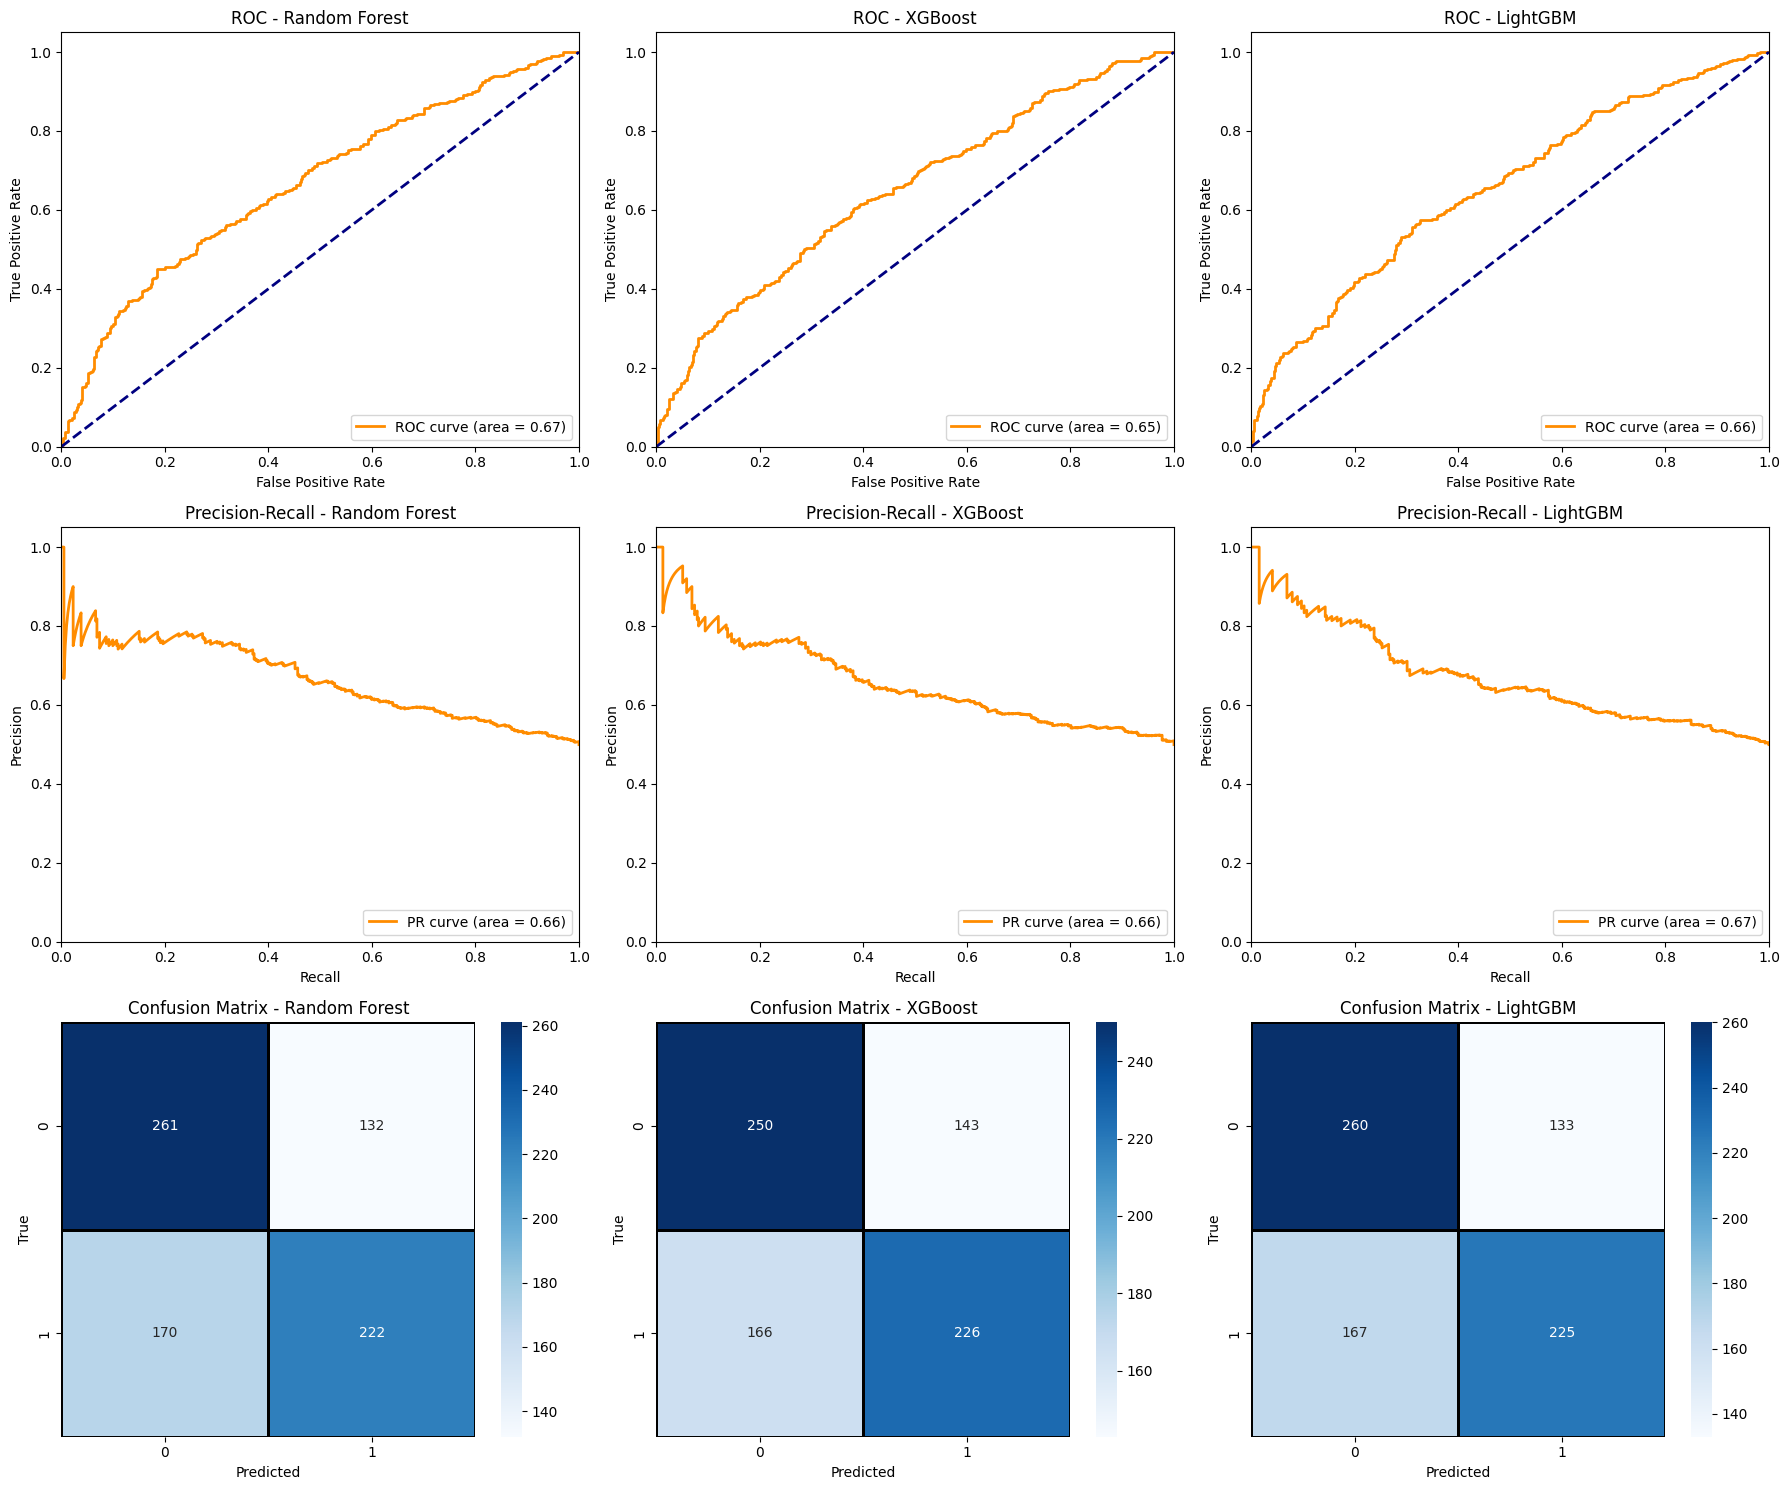

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6152866242038216, 'Precision': 0.6271186440677966, 'Recall': 0.5663265306122449, 'F1 Score': 0.5951742627345844, 'ROC AUC': 0.6659591317443008}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6063694267515923, 'Precision': 0.6124661246612466, 'Recall': 0.576530612244898, 'F1 Score': 0.5939553219448095, 'ROC AUC': 0.6500752972944903}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.6178343949044586, 'Precision': 0.6284916201117319, 'Recall': 0.5739795918367347, 'F1 Score': 0.6000000000000001, 'ROC AUC': 0.6577283585189801}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.6178343949044586,
 'Precision': 0.6284916201117319,
 'Recall': 0.5739795918367347,
 'F1 Score': 0.6000000000000001,
 'ROC AUC': 0.6577283585189801}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.6178


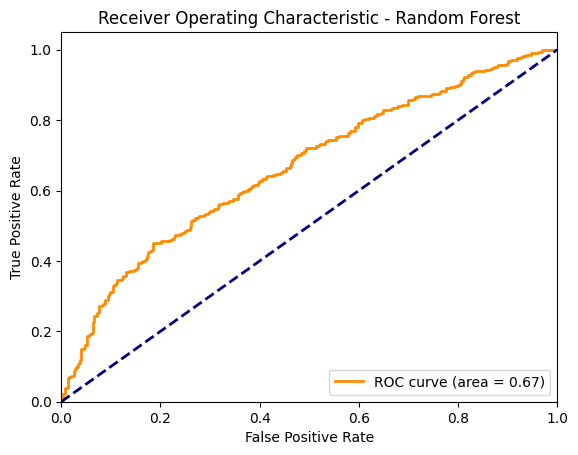

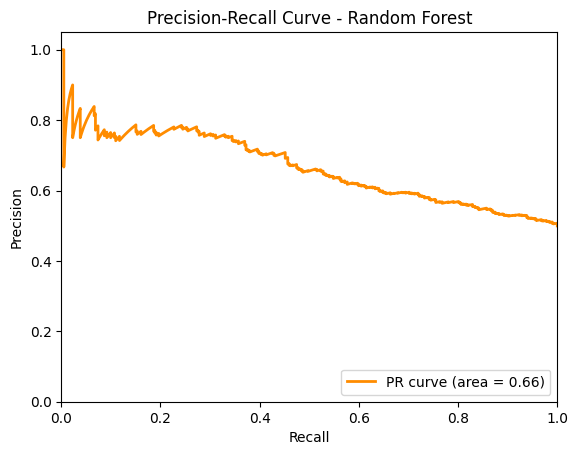

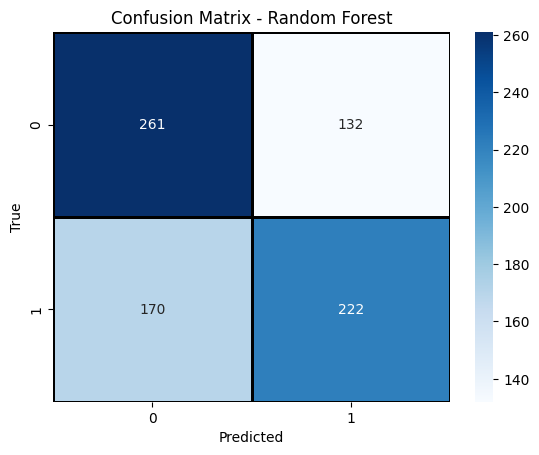

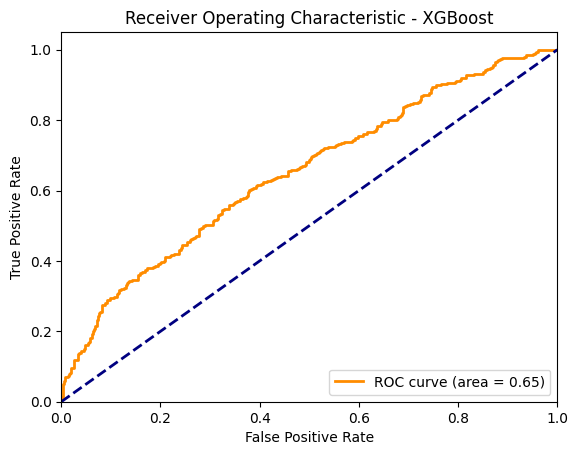

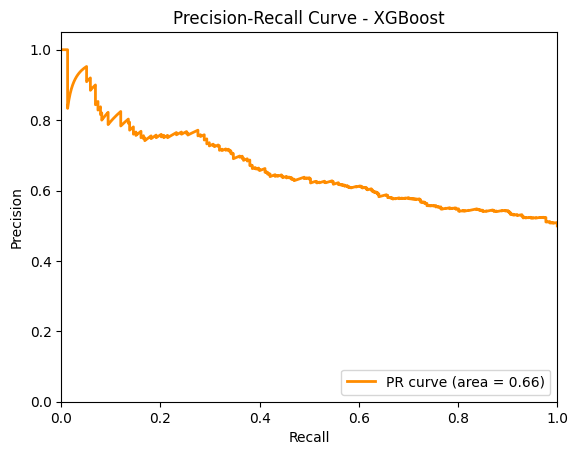

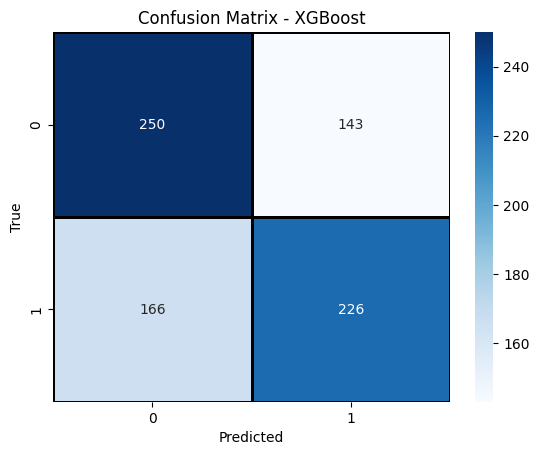

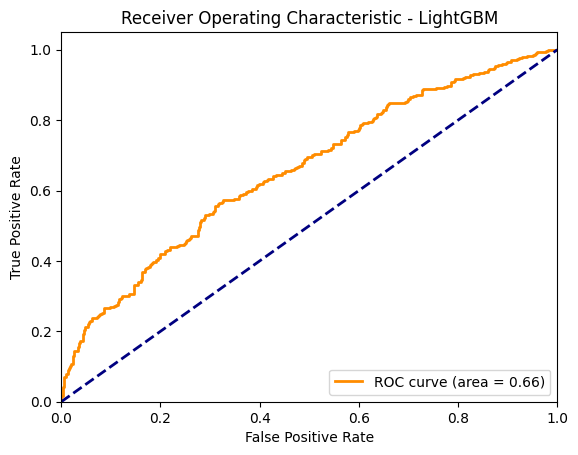

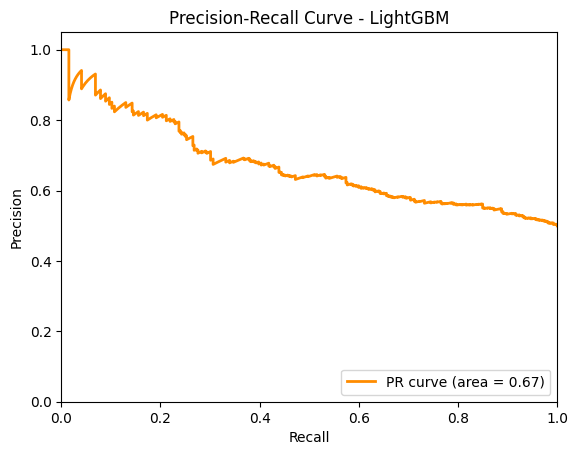

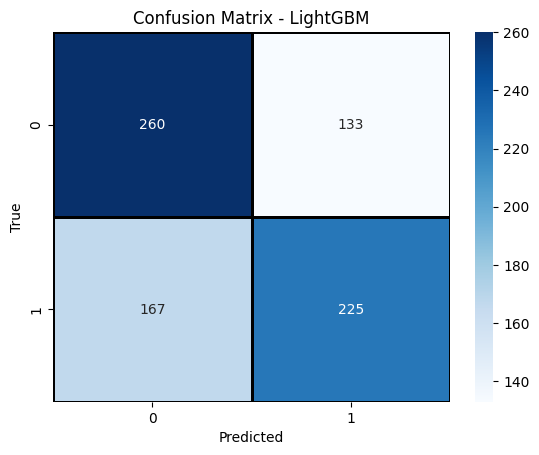

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

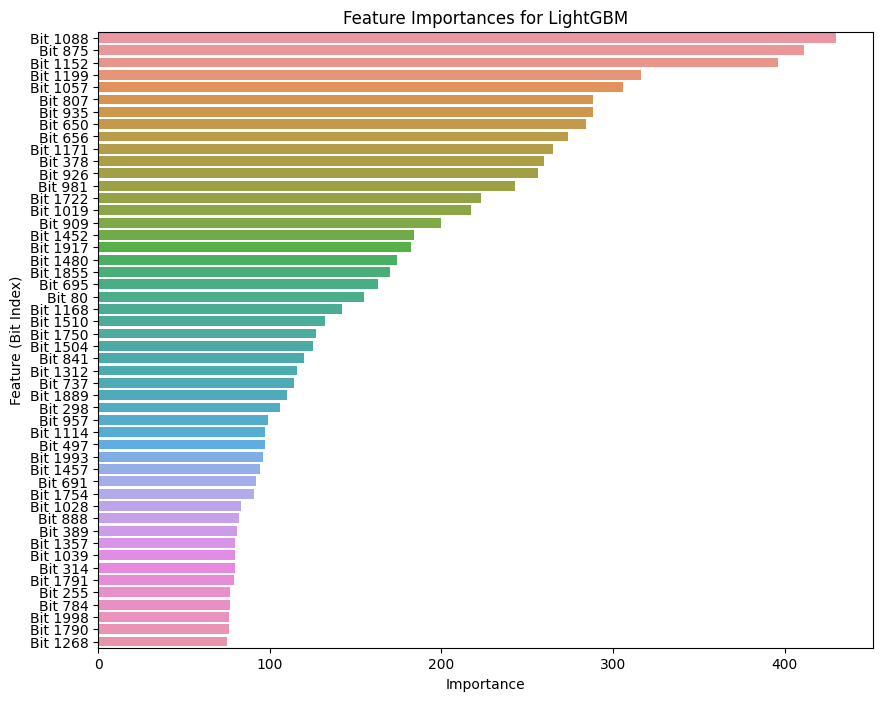

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
